### Goal
- prepare stats data for machine learning

### Steps
- : review dtypes,and prepare continuous numeric, discrete numeric, categorical, character and identity columns
Input: nfl_weekly_stats.parquet
Work:
    - separate continuous numeric, discrete numeric, categorical, character and identity columns
    - label encode
    - merge all back together
Output:
    - nfl_ml_weekly_stats.parquet - cleaned, labeled data

In [20]:
import os
import sys
sys.path.append(os.path.abspath("../src"))


In [21]:
from src import *


In [22]:
logger = configs.configure_logging("pbp_logger")
logger.setLevel(logging.INFO)

#### load stats data

In [23]:

input_file_name = "nfl_weekly_offense"
power_column = "offense_power"

data_directory = get_config('data_directory')
input_path = os.path.join(data_directory,  f"{input_file_name}.parquet")
assert  os.path.exists(input_path)

original_stats_df = pd.read_parquet(input_path)
original_stats_df.head()

,team,season,week,passing_yards,avg_rushing_epa,receiving_first_downs,passing_yards_after_catch,ps_completions,ps_attempts,receiving_yards,...,player_jersey_number,avg_time_to_los,team_score,team_coach,opposing_team,opposing_score,opposing_coach,spread,count,win
index,,,,,,,,,,,,,,,,,,,,,
0,ARI,2016,1,271.0,0.209866,14.0,105.0,24.0,37.0,271.0,...,31.0,2.616188,21,Bruce Arians,NE,23,Bill Belichick,-2.0,1,loss
1,ARI,2016,2,315.0,-0.273297,15.0,157.0,18.0,34.0,315.0,...,23.0,2.450687,40,Bruce Arians,TB,7,Dirk Koetter,33.0,1,win
2,ARI,2016,3,287.0,-0.916674,17.0,90.0,26.0,50.0,287.0,...,31.0,2.619000,18,Bruce Arians,BUF,33,Rex Ryan,-15.0,1,loss
3,ARI,2016,4,325.0,-0.472056,17.0,116.0,27.0,47.0,325.0,...,31.0,2.700235,13,Bruce Arians,LA,17,Jeff Fisher,-4.0,1,loss
4,ARI,2016,5,124.0,0.499843,6.0,49.0,11.0,28.0,124.0,...,31.0,2.667074,33,Bruce Arians,SF,21,Chip Kelly,12.0,1,win


#### drop columns we don't need

In [24]:
from src.build_power_scores import prepare_power_data

features_df = prepare_power_data(original_stats_df)


2023-07-17 22:57:48,795 - INFO - encode the target win/loss column
2023-07-17 22:57:48,797 - INFO - create a features dataframe for feature selection ...
2023-07-17 22:57:48,798 - INFO - scale all features  ...


#### scale numeric data for ml feature selection

#### review correlations

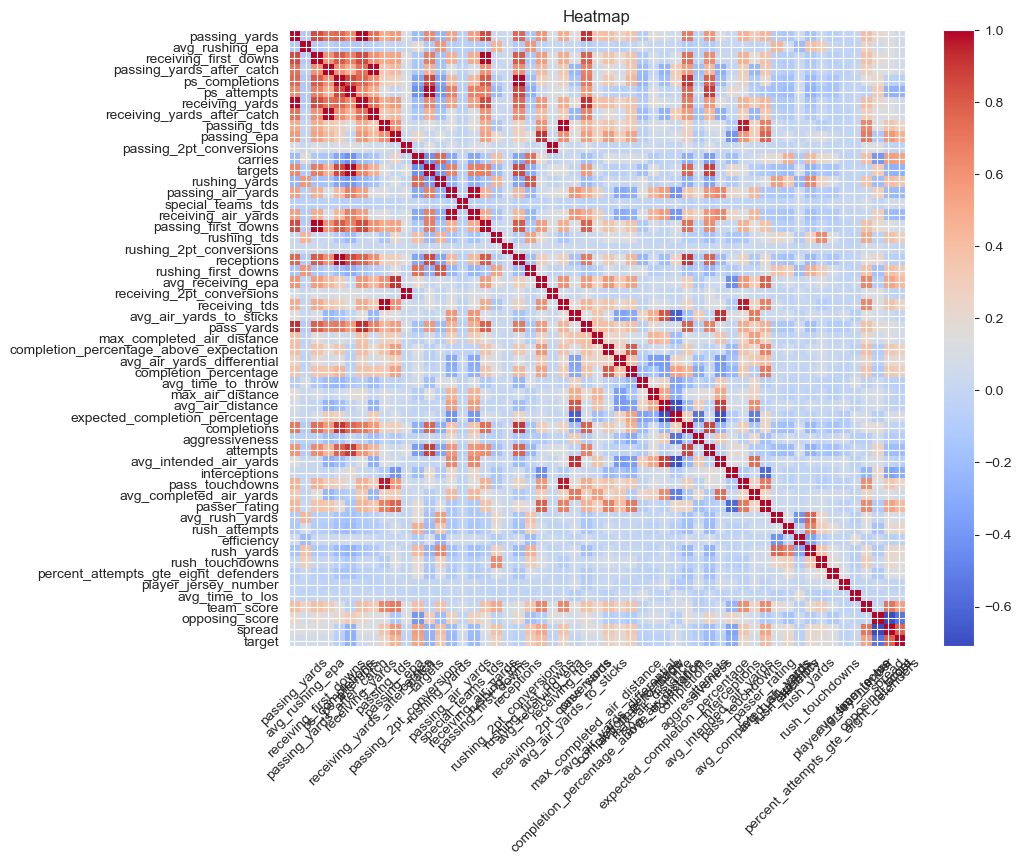

In [25]:
from src.utils_eda import plot_heatmap

# Create heatmap using plt.imshow()
numeric_df = original_stats_df.select_dtypes(include='number').drop(columns=['season', 'week',  'count'])
plot_heatmap(original_stats_df, drop_columns=['season', 'week',  'count'])

### best correlations to target

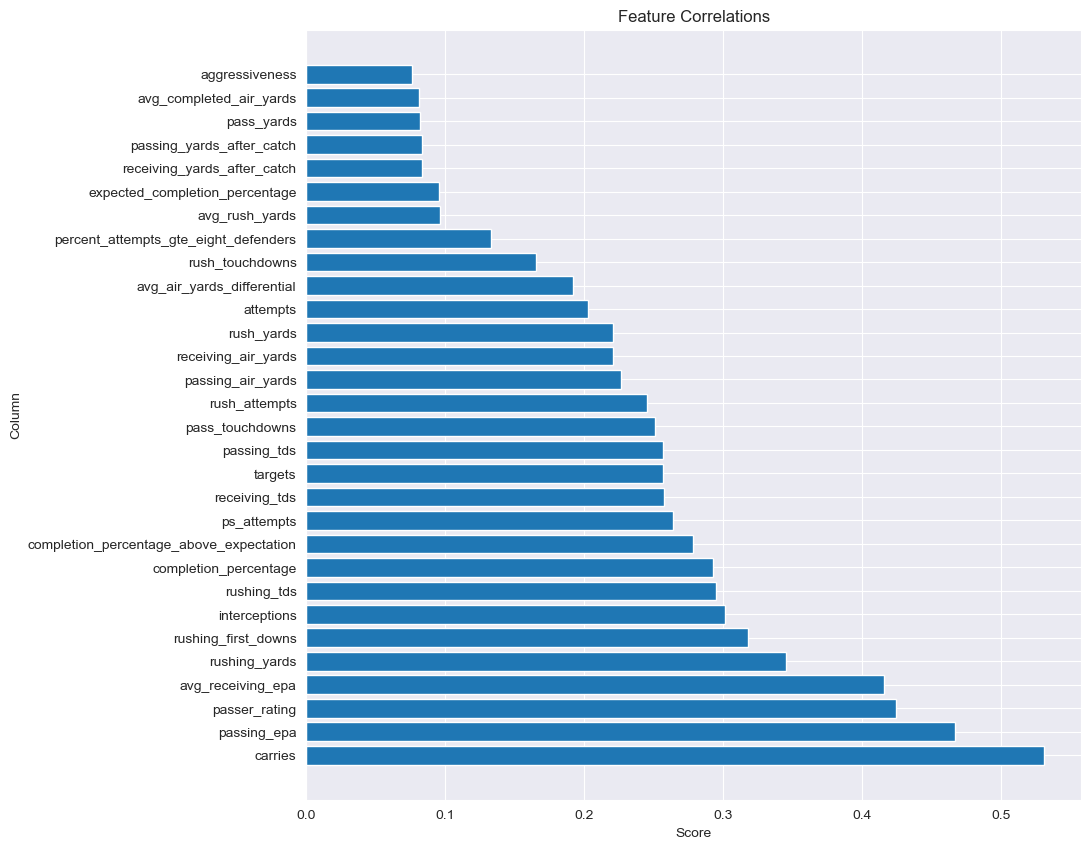

In [26]:
from src.utils_eda import correlate_to_target, plot_correlations

top_correlations, set_correlations = correlate_to_target(features_df, 'target', 30)
plot_correlations(top_correlations['corr'], top_correlations['y'], 'Feature Correlations')


### train xgboost feature model

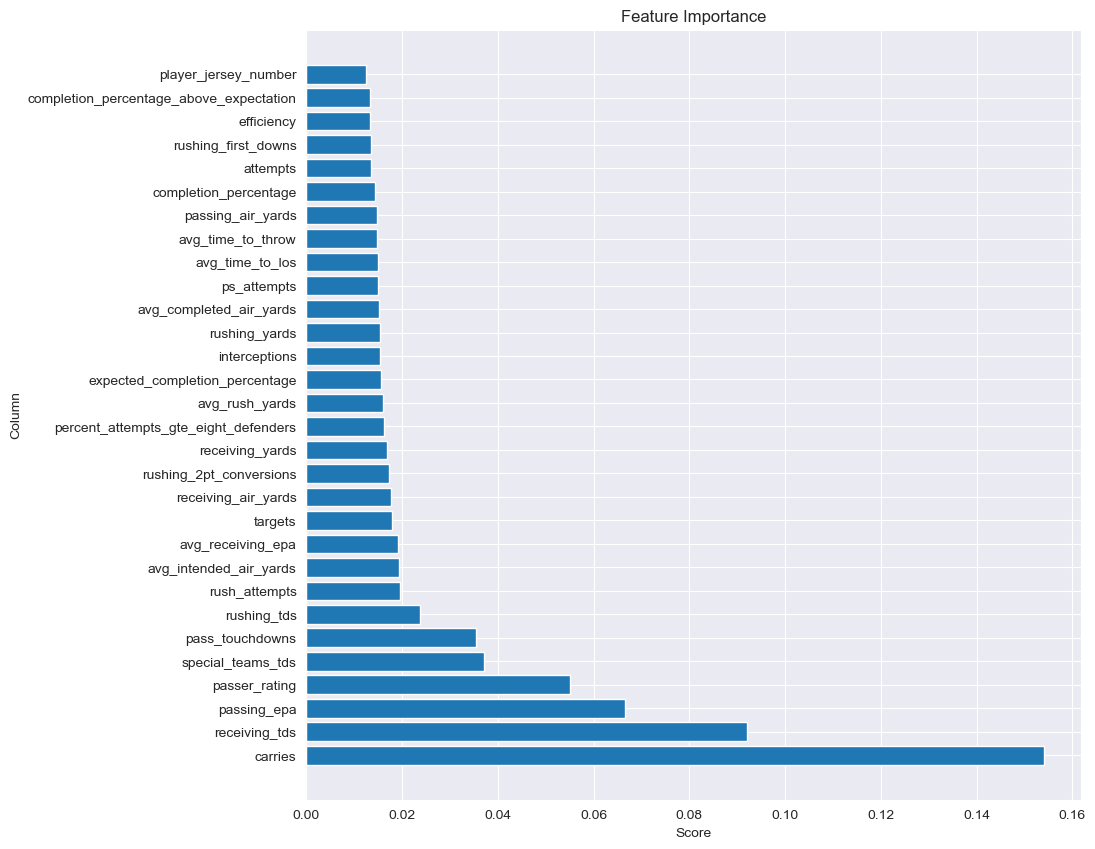

In [27]:
from src.utils_eda import calc_feature_importance

y = features_df.pop('target')

top_features, set_features = calc_feature_importance(features_df, y, top_n=30)
plot_correlations(top_features['corr'], top_features['y'], "Feature Importance")

### concat a weighted average "power" score to the stats dataset

In [28]:
from src.build_power_scores import concat_power_score

concat_power_score(df=original_stats_df, summary_data=top_features, threshold=.01, power_column=power_column)
original_stats_df.head()

2023-07-17 22:57:52,472 - INFO - get percentage contribution of offensive and defensive features
2023-07-17 22:57:52,476 - INFO - calculate weighted average of offensive and defensive features


,team,season,week,passing_yards,avg_rushing_epa,receiving_first_downs,passing_yards_after_catch,ps_completions,ps_attempts,receiving_yards,...,team_score,team_coach,opposing_team,opposing_score,opposing_coach,spread,count,win,target,offense_power
index,,,,,,,,,,,,,,,,,,,,,
0,ARI,2016,1,271.0,0.209866,14.0,105.0,24.0,37.0,271.0,...,21,Bruce Arians,NE,23,Bill Belichick,-2.0,1,loss,0,32.768561
1,ARI,2016,2,315.0,-0.273297,15.0,157.0,18.0,34.0,315.0,...,40,Bruce Arians,TB,7,Dirk Koetter,33.0,1,win,1,36.522021
2,ARI,2016,3,287.0,-0.916674,17.0,90.0,26.0,50.0,287.0,...,18,Bruce Arians,BUF,33,Rex Ryan,-15.0,1,loss,0,35.382326
3,ARI,2016,4,325.0,-0.472056,17.0,116.0,27.0,47.0,325.0,...,13,Bruce Arians,LA,17,Jeff Fisher,-4.0,1,loss,0,36.997307
4,ARI,2016,5,124.0,0.499843,6.0,49.0,11.0,28.0,124.0,...,33,Bruce Arians,SF,21,Chip Kelly,12.0,1,win,1,30.315118


#### sanity check the power score

In [29]:
X = original_stats_df[[ power_column ]]
y = original_stats_df[[ 'target']]


In [30]:
from src.build_power_scores import create_shallow_model

model, callbacks = create_shallow_model(X)

r = model.fit(X, y, epochs=200, batch_size=64, verbose=0, validation_split=0.2, callbacks=callbacks)

2023-07-17 22:57:55.527780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-17 22:57:56.038884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


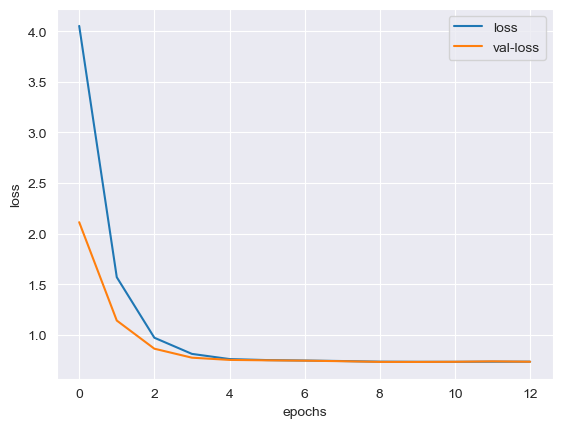

In [31]:
from src.utils_eda import plot_loss

plot_loss(r)

### save the dataset

In [32]:
%%time

data_directory = get_config('data_directory')
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

output_path = os.path.join(data_directory, f"{input_file_name}_ml.parquet")
original_stats_df.to_parquet(output_path, engine='fastparquet', compression='snappy')

CPU times: user 22.1 ms, sys: 2.95 ms, total: 25.1 ms
Wall time: 25.4 ms
